## Initialization

In [62]:
%matplotlib inline

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os, json
import re

## Read Data

In [3]:
if os.path.exists('dataset/train.csv'):
    data = pd.read_csv('dataset/train.csv', error_bad_lines=False)

## Preprocessing

Subset failed inspections.

In [4]:
high_ratings = data[['review/overall','review/text']]
high_ratings.head()

,review/overall,review/text
0,4.0,Pours a clouded gold with a thin white head. N...
1,3.5,12oz bottle into 8oz snifter.\t\tDeep ruby red...
2,3.5,First enjoyed at the brewpub about 2 years ago...
3,2.5,First thing I noticed after pouring from green...
4,3.0,A: pours an amber with a one finger head but o...


## Remove Punctuation and Number

In [5]:
import nltk
import string
from string import digits

In [6]:
remove_punctuation = str.maketrans('', '', string.punctuation)
remove_digits = str.maketrans('', '', digits)

In [14]:
def clean_column(df,colname):
    df[colname] = df[colname].str.translate(remove_punctuation)
    df[colname] = df[colname].str.translate(remove_digits)
    df[colname] = df[colname].str.lower()

In [20]:
clean_column(high_ratings,'review/text')

In [23]:
clean_df = high_ratings

In [24]:
clean_df.head()

,review/overall,review/text
0,4.0,pours a clouded gold with a thin white head no...
1,3.5,oz bottle into oz snifter\t\tdeep ruby red hue...
2,3.5,first enjoyed at the brewpub about years ago ...
3,2.5,first thing i noticed after pouring from green...
4,3.0,a pours an amber with a one finger head but on...


### Subset Clean_df

Subset the entries for the top 10 violations.

In [29]:
clean_df_subset = clean_df.loc[clean_df['review/overall']>=4]

In [30]:
clean_df_subset.head()

,review/overall,review/text
0,4.0,pours a clouded gold with a thin white head no...
5,4.0,served in a snifter ontap at cbc\t\tcolor is t...
6,4.0,my th review ontap mini snifter\t\t a nutty da...
7,4.0,one of the better pumpkin ales ive tried so fa...
8,4.5,a snifter filled several times over from a ml ...


In [31]:
clean_df_subset.shape

(25205, 2)

### Tokenization

In [33]:
from nltk.tokenize import sent_tokenize, word_tokenize

In [34]:
def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

In [35]:
clean_df_subset['review/text'] = clean_df_subset['review/text'].astype('str')
comment_tokens = clean_df_subset['review/text'].apply(tokenize_only)

C:\Users\pmann\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


### Remove Stopwords

In [36]:
from nltk.corpus import stopwords
stop = stopwords.words('english')

In [37]:
comment_tokens_filtered = comment_tokens.apply(lambda x: [item for item in x if item not in stop])

In [38]:
comment_tokens_filtered.head()

0    [pours, clouded, gold, thin, white, head, nose...
5    [served, snifter, ontap, cbc, color, typical, ...
6    [th, review, ontap, mini, snifter, nutty, dark...
7    [one, better, pumpkin, ales, ive, tried, far, ...
8    [snifter, filled, several, times, ml, bottle, ...
Name: review/text, dtype: object

In [72]:
comment_tokens_filtered.to_csv('all_reviews.txt', sep=' ', index=False)

### Count Word Frequency

In [39]:
def count_word_freq(pd_series):
    tokens_flat = list(pd_series.values.flatten())
    tokens_flat_list = [item for sublist in tokens_flat for item in sublist]
    value_counts = pd.Series(tokens_flat_list).value_counts()
    count = value_counts.rename_axis('unique_values').reset_index(name='counts')
    return count

In [66]:
popular_terms = count_word_freq(comment_tokens_filtered)
popular_terms = popular_terms.loc[popular_terms['counts'] > 5000]

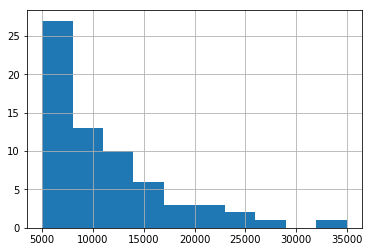

In [67]:
popular_terms['counts'].hist()

In [68]:
popular_terms

,unique_values,counts
0,beer,34937
1,veri,27312
2,head,24920
3,hop,24051
4,malt,22314
5,tast,21778
6,nice,21409
7,flavor,19803
8,sweet,19328
9,pour,19325


## Final Option-A: 1-2 N-Grams + Lemmatizer + TFIDF + Grouped per Code

In [69]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [70]:
def show_terms_related_to_violation(code,df,code_colname,term_colname):
    tfidf_vectorizer = TfidfVectorizer(
        max_df=0.2, max_features=200000,
        min_df=0.05, stop_words='english',
        use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,2)
    )
    
    tfidf_df = df.loc[df[code_colname] == code][colname]
    rel_terms_matrix = tfidf_vectorizer.fit_transform(tfidf_df)
    rel_terms = tfidf_vectorizer.get_feature_names()

    print("Rating: " + str(code))
    print()
    print("Relevant terms:")
    print(rel_terms)
    print("-"*10)
    print()

In [71]:
for code in [4.0,4.5,5.0]:
    show_terms_related_to_violation(code,clean_df_subset,'review/overall','review/text')

Rating: 4.0

Relevant terms:
['abv', 'aftertast', 'age', 'ale', 'amber', 'amber color', 'ani', 'anoth', 'appear', 'bad', 'befor', 'best', 'better', 'big', 'bite', 'black', 'bottl pour', 'bourbon', 'breadi', 'brew', 'bubbl', 'burnt', 'caramel malt', 'charact', 'citrus', 'clean', 'clear', 'cloudi', 'coffe', 'come', 'complex', 'copper', 'creami', 'crisp', 'd', 'dark brown', 'dark chocol', 'dark fruit', 'decent', 'deep', 'definit', 'dissip', 'doe', 'doesnt', 'domin', 'dont', 'dri', 'earthi', 'easi', 'easi drink', 'edg', 'end', 'enjoy', 'excel', 'expect', 'fade', 'faint', 'fair', 'feel', 'fine', 'finger', 'floral', 'foam', 'follow', 'founder', 'fresh', 'fruit', 'fruiti', 'goe', 'golden', 'got', 'grain', 'grapefruit', 'hazi', 'heavi', 'high', 'hit', 'hop bitter', 'hoppi', 'huge', 'id', 'im', 'inch', 'ipa', 'isnt', 'ive', 'lace glass', 'lace s', 'lace smell', 'leav', 'left', 'linger', 'long', 'look', 'lot', 'love', 'low', 'make', 'malti', 'mayb', 'medium bodi', 'mild', 'mix', 'moder', 'mouth'